###IMPORTING LIBRARY

In [1]:
import numpy as np
import pandas as pd 
import re
import os
import json
import pickle
from tqdm import tqdm
import glob
import matplotlib.pyplot as plt
from bs4 import BeautifulSoup
from keras.preprocessing.text import Tokenizer 
from keras.utils import pad_sequences
from keras_preprocessing.sequence import pad_sequences
from nltk.corpus import stopwords
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate, TimeDistributed,Bidirectional
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
import warnings
pd.set_option("display.max_colwidth", 200)
warnings.filterwarnings("ignore")

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


###TAKING SEGMENTED DATASET

In [3]:
# load the meta data from the CSV file using 3 columns (abstract, title, authors),
df = pd.read_excel("/content/drive/MyDrive/Directed/metadataFinal.xlsx",usecols=["title", "abstract"], nrows =10000)
print(df.shape)

(10000, 2)


In [4]:
df.info

<bound method DataFrame.info of                                                                                                                                                                   title  \
0                                                                                                                                                           Correction.   
1                                                                                                                                                       Correspondence.   
2                                                                                                                                                            Editorial.   
3                                                                                                                                                            Editorial.   
4                                                                                                                

In [5]:
df.head()

,title,abstract
0,Correction.,[This corrects the article on p. 147 in vol. 33.].
1,Correspondence.,NaN
2,Editorial.,NaN
3,Editorial.,NaN
4,Editorial.,NaN


##DATA PREPROCESSING

In [6]:
df.isna().sum()

title          1
abstract    1184
dtype: int64

In [7]:
df.drop_duplicates(subset=['abstract'],inplace=True)#dropping duplicates
df.dropna(axis=0,inplace=True)#dropping na

In [8]:
data = df[['title','abstract']]

In [9]:
data.head()

,title,abstract
0,Correction.,[This corrects the article on p. 147 in vol. 33.].
11,A bioactive compliant vascular graft modulates macrophage polarization and maintains patency with robust vascular remodeling.,Conventional synthetic vascular grafts are associated with significant failure rates due to their mismatched mechanical properties with the native vessel and poor regenerative potential. Though di...
12,Strategies to increase rural maternal utilization of skilled health personnel for childbirth delivery in low- and middle-income countries: a narrative review.,BACKGROUND Skilled attendance at birth is considered key to accomplishing Sustainable Development Goal (SDG) 3.1 aimed at reducing maternal mortality. Many maternal deaths can be prevented if a wo...
13,"A ‘Multiomic’ Approach of Saliva Metabolomics, Microbiota, and Serum Biomarkers to Assess the Need of Hospitalization in Coronavirus Disease 2019",Background and Aims The SARS-CoV-2 pandemic has overwhelmed the treatment capacity of the health care systems during the highest viral diffusion rate. Patients reaching the emergency department ha...
14,Chapter 8 Infectious Disease Emergencies,"COVID-19 has added new relevance to the relationship between the world’s public health and infectious diseases and makes timely the topic of this chapter, that is, infectious disease emergencies. ..."


In [10]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8810 entries, 0 to 9999
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   title     8810 non-null   object
 1   abstract  8810 non-null   object
dtypes: object(2)
memory usage: 206.5+ KB


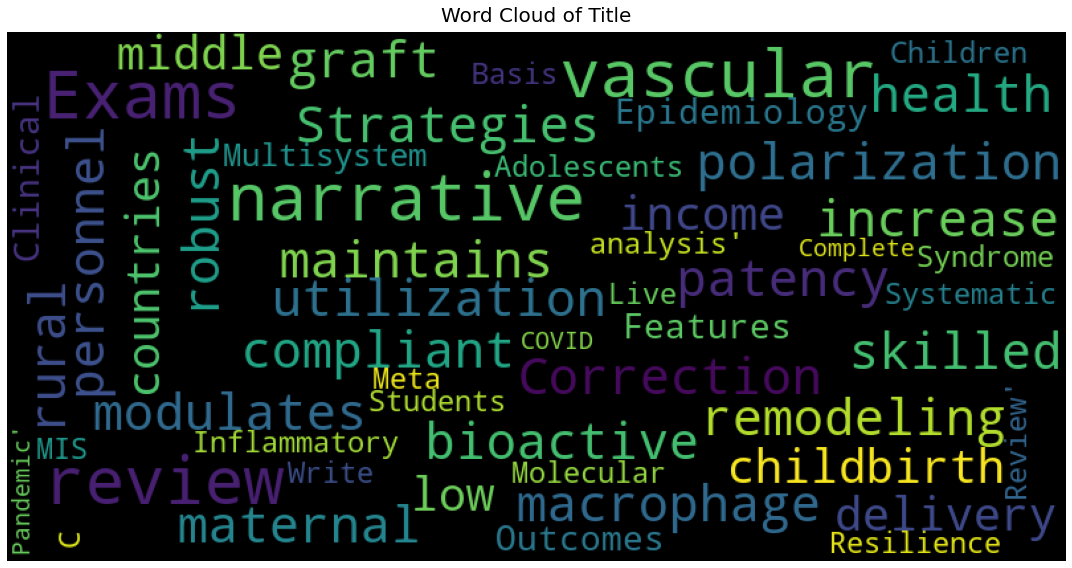

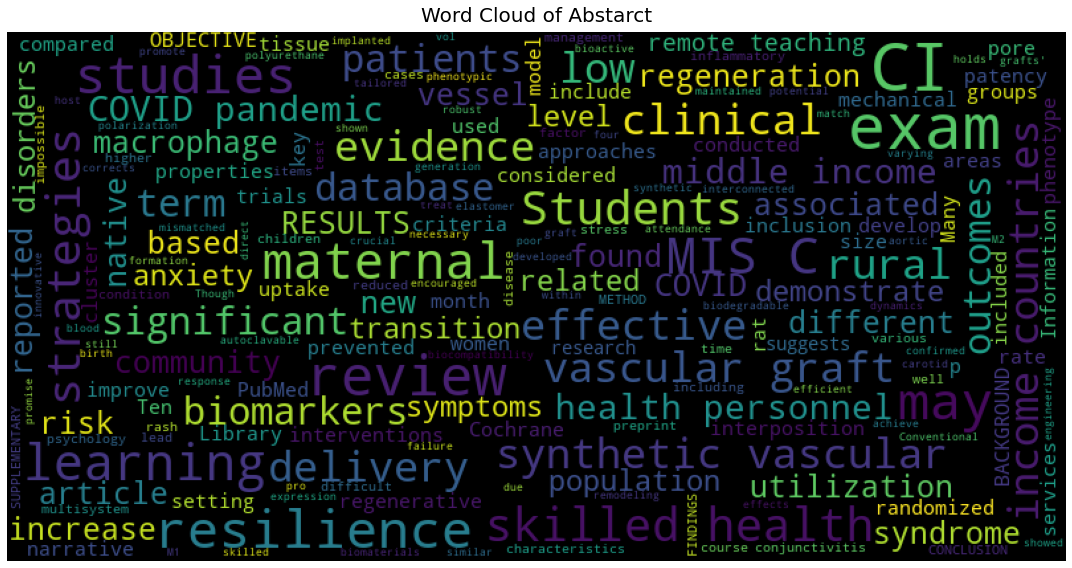

In [11]:
from wordcloud import WordCloud, STOPWORDS

# Thanks : https://www.kaggle.com/aashita/word-clouds-of-various-shapes ##
def plot_wordcloud(text, mask=None, max_words=200, max_font_size=50, figure_size=(15.0,15.0), 
                   title = None, title_size=20, image_color=False,color = None):
    stopwords = set(STOPWORDS)
    more_stopwords = {'one', 'br', 'Po', 'th', 'sayi', 'fo', 'Unknown'}
    stopwords = stopwords.union(more_stopwords)

    wordcloud = WordCloud(background_color=color,
                    stopwords = stopwords,
                    max_words = max_words,
                    max_font_size = max_font_size, 
                    random_state = 42,
                    width=800, 
                    height=400,
                    mask = mask)
    wordcloud.generate(str(text))
    
    plt.figure(figsize=figure_size)
    if image_color:
        image_colors = ImageColorGenerator(mask);
        plt.imshow(wordcloud.recolor(color_func=image_colors), interpolation="bilinear");
        plt.title(title, fontdict={'size': title_size,  
                                  'verticalalignment': 'bottom'})
    else:
        plt.imshow(wordcloud);
        plt.title(title, fontdict={'size': title_size, 'color': 'black', 
                                  'verticalalignment': 'bottom'})
    plt.axis('off');
    plt.tight_layout()  
    
plot_wordcloud(data['title'].values, title="Word Cloud of Title",color = 'black')
plot_wordcloud(data['abstract'].values, title="Word Cloud of Abstarct",color = 'black')

##DATA CLEANING

In [12]:
# A list of contractions from http://stackoverflow.com/questions/19790188/expanding-english-language-contractions-in-python

contraction_mapping = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not",
                           "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not",
                           "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",
                           "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would",
                           "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",
                           "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam",
                           "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have",
                           "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock",
                           "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have",
                           "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is",
                           "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as",
                           "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would",
                           "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have",
                           "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have",
                           "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are",
                           "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",
                           "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is",
                           "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have",
                           "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have",
                           "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all",
                           "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",
                           "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have",
                           "you're": "you are", "you've": "you have"}

In [13]:
import nltk
nltk.download('stopwords')

stop_words = set(stopwords.words('english')) 

def text_cleaner(text,num):
    newString = text.lower()
    newString = BeautifulSoup(newString, "lxml").text
    newString = re.sub(r'\([^)]*\)', '', newString)
    newString = re.sub('"','', newString)
    newString = ' '.join([contraction_mapping[t] if t in contraction_mapping else t for t in newString.split(" ")])    
    newString = re.sub(r"'s\b","",newString)
    newString = re.sub("[^a-zA-Z]", " ", newString) 
    newString = re.sub('[m]{2,}', 'mm', newString)
    if(num==0):
        tokens = [w for w in newString.split() if not w in stop_words]
    else:
        tokens=newString.split()
    long_words=[]
    for i in tokens:
        if len(i)>1:                                                 #removing short word
            long_words.append(i)   
    return (" ".join(long_words)).strip()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [14]:
#call the function
cleaned_text = []
for t in data['abstract']:
    cleaned_text.append(text_cleaner(t,0))

In [15]:
cleaned_text[:3]

['corrects article vol',
 'conventional synthetic vascular grafts associated significant failure rates due mismatched mechanical properties native vessel poor regenerative potential though different tissue engineering approaches used improve biocompatibility synthetic vascular grafts still crucial develop new generation synthetic grafts match dynamics native vessel direct host response achieve robust vascular regeneration size pores within implanted biomaterials shown significant effects macrophage polarization confirmed necessary efficient vascular formation remodeling developed biodegradable autoclavable synthetic vascular grafts new polyurethane elastomer tailored grafts interconnected pore sizes promote macrophage populations pro regenerative phenotype improve vascular regeneration patency rate synthetic vascular grafts showed similar mechanical properties native blood vessels encouraged macrophage populations varying phenotypic expression maintained patency vascular regeneration o

In [16]:
#call the function
cleaned_summary = []
for t in data['title']:
    cleaned_summary.append(text_cleaner(t,0))

In [17]:
cleaned_summary[:5]

['correction',
 'bioactive compliant vascular graft modulates macrophage polarization maintains patency robust vascular remodeling',
 'strategies increase rural maternal utilization skilled health personnel childbirth delivery low middle income countries narrative review',
 'multiomic approach saliva metabolomics microbiota serum biomarkers assess need hospitalization coronavirus disease',
 'chapter infectious disease emergencies']

In [18]:
data['cleaned_text']=cleaned_text
data['cleaned_summary']=cleaned_summary

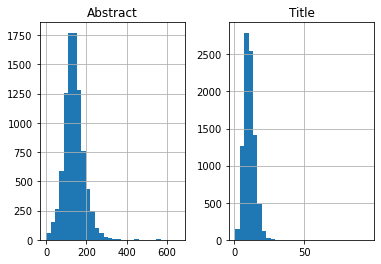

In [19]:
text_word_count = []
summary_word_count = []

# populate the lists with sentence lengths
for i in data['cleaned_text']:
      text_word_count.append(len(i.split()))

for i in data['cleaned_summary']:
      summary_word_count.append(len(i.split()))

length_df = pd.DataFrame({'Abstract':text_word_count, 'Title':summary_word_count})

length_df.hist(bins = 30)
plt.show()

In [20]:
data['cleaned_summary'] = data['cleaned_summary'].apply(lambda x : 'sostok '+ x + ' eostok')

In [21]:
max_text_len = 100
max_summary_len = 35

In [22]:
from sklearn.model_selection import train_test_split
x_tr,x_val,y_tr,y_val=train_test_split(np.array(data['cleaned_text']),np.array(data['cleaned_summary']),test_size=0.1,random_state=0,shuffle=True)

In [24]:
from keras.preprocessing.text import Tokenizer 

#prepare a tokenizer for reviews on training data
x_tokenizer = Tokenizer() 
x_tokenizer.fit_on_texts(list(x_tr))

In [25]:
thresh=5

cnt=0
tot_cnt=0
freq=0
tot_freq=0

for key,value in x_tokenizer.word_counts.items():
    tot_cnt=tot_cnt+1
    tot_freq=tot_freq+value
    if(value<thresh):
        cnt=cnt+1
        freq=freq+value
    
print("% of rare words in vocabulary:",(cnt/tot_cnt)*100)
print("Total Coverage of rare words:",(freq/tot_freq)*100)

% of rare words in vocabulary: 62.23902087832973
Total Coverage of rare words: 3.79966494955589


In [26]:
#prepare a tokenizer for reviews on training data
x_tokenizer = Tokenizer(num_words=tot_cnt-cnt) 
x_tokenizer.fit_on_texts(list(x_tr))

#convert text sequences into integer sequences
x_tr_seq    =   x_tokenizer.texts_to_sequences(x_tr) 
x_val_seq   =   x_tokenizer.texts_to_sequences(x_val)

#padding zero upto maximum lengath
x_tr    =   pad_sequences(x_tr_seq,maxlen=max_text_len, padding='post')
x_val   =   pad_sequences(x_val_seq,maxlen=max_text_len, padding='post')

#size of vocabulary ( +1 for padding token)
x_voc   =  x_tokenizer.num_words + 1

In [27]:
#prepare a tokenizer for reviews on training data
y_tokenizer = Tokenizer()   
y_tokenizer.fit_on_texts(list(y_tr))

In [28]:
thresh=7

cnt=0
tot_cnt=0
freq=0
tot_freq=0

for key,value in y_tokenizer.word_counts.items():
    tot_cnt=tot_cnt+1
    tot_freq=tot_freq+value
    if(value<thresh):
        cnt=cnt+1
        freq=freq+value
    
print("% of rare words in vocabulary:",(cnt/tot_cnt)*100)
print("Total Coverage of rare words:",(freq/tot_freq)*100)

% of rare words in vocabulary: 84.35897435897436
Total Coverage of rare words: 19.54113081932631


In [29]:
#prepare a tokenizer for reviews on training data
y_tokenizer = Tokenizer(num_words=tot_cnt-cnt) 
y_tokenizer.fit_on_texts(list(y_tr))

#convert text sequences into integer sequences
y_tr_seq    =   y_tokenizer.texts_to_sequences(y_tr) 
y_val_seq   =   y_tokenizer.texts_to_sequences(y_val) 

#padding zero upto maximum length
y_tr    =   pad_sequences(y_tr_seq, maxlen=max_summary_len, padding='post')
y_val   =   pad_sequences(y_val_seq, maxlen=max_summary_len, padding='post')

#size of vocabulary
y_voc  =   y_tokenizer.num_words +1

In [30]:
y_tokenizer.word_counts['sostok'],len(y_tr)

(7929, 7929)

In [31]:
ind=[]
for i in range(len(y_tr)):
    cnt=0
    for j in y_tr[i]:
        if j!=0:
            cnt=cnt+1
    if(cnt==2):
        ind.append(i)

y_tr=np.delete(y_tr,ind, axis=0)
x_tr=np.delete(x_tr,ind, axis=0)

In [32]:
ind=[]
for i in range(len(y_val)):
    cnt=0
    for j in y_val[i]:
        if j!=0:
            cnt=cnt+1
    if(cnt==2):
        ind.append(i)

y_val=np.delete(y_val,ind, axis=0)
x_val=np.delete(x_val,ind, axis=0)

##NLP MODEL

In [33]:
from tensorflow.keras import layers
import tensorflow as tf
from tensorflow.python.keras import backend as K

logger = tf.get_logger()

In [34]:
class AttentionLayer(tf.keras.layers.Layer):
    """
    This class implements Bahdanau attention (https://arxiv.org/pdf/1409.0473.pdf).
    There are three sets of weights introduced W_a, U_a, and V_a
     """

    def __init__(self, **kwargs):
        super(AttentionLayer, self).__init__(**kwargs)

    def build(self, input_shape):
        assert isinstance(input_shape, list)
        # Create a trainable weight variable for this layer.

        self.W_a = self.add_weight(name='W_a',
                                   shape=tf.TensorShape((input_shape[0][2], input_shape[0][2])),
                                   initializer='uniform',
                                   trainable=True)
        self.U_a = self.add_weight(name='U_a',
                                   shape=tf.TensorShape((input_shape[1][2], input_shape[0][2])),
                                   initializer='uniform',
                                   trainable=True)
        self.V_a = self.add_weight(name='V_a',
                                   shape=tf.TensorShape((input_shape[0][2], 1)),
                                   initializer='uniform',
                                   trainable=True)

        super(AttentionLayer, self).build(input_shape)  # Be sure to call this at the end

    def call(self, inputs):
        """
        inputs: [encoder_output_sequence, decoder_output_sequence]
        """
        assert type(inputs) == list
        encoder_out_seq, decoder_out_seq = inputs

        logger.debug(f"encoder_out_seq.shape = {encoder_out_seq.shape}")
        logger.debug(f"decoder_out_seq.shape = {decoder_out_seq.shape}")

        def energy_step(inputs, states):
            """ Step function for computing energy for a single decoder state
            inputs: (batchsize * 1 * de_in_dim)
            states: (batchsize * 1 * de_latent_dim)
            """

            logger.debug("Running energy computation step")

            if not isinstance(states, (list, tuple)):
                raise TypeError(f"States must be an iterable. Got {states} of type {type(states)}")

            encoder_full_seq = states[-1]

            """ Computing S.Wa where S=[s0, s1, ..., si]"""
            # <= batch size * en_seq_len * latent_dim
            W_a_dot_s = K.dot(encoder_full_seq, self.W_a)

            """ Computing hj.Ua """
            U_a_dot_h = K.expand_dims(K.dot(inputs, self.U_a), 1)  # <= batch_size, 1, latent_dim

            logger.debug(f"U_a_dot_h.shape = {U_a_dot_h.shape}")

            """ tanh(S.Wa + hj.Ua) """
            # <= batch_size*en_seq_len, latent_dim
            Ws_plus_Uh = K.tanh(W_a_dot_s + U_a_dot_h)

            logger.debug(f"Ws_plus_Uh.shape = {Ws_plus_Uh.shape}")

            """ softmax(va.tanh(S.Wa + hj.Ua)) """
            # <= batch_size, en_seq_len
            e_i = K.squeeze(K.dot(Ws_plus_Uh, self.V_a), axis=-1)
            # <= batch_size, en_seq_len
            e_i = K.softmax(e_i)

            logger.debug(f"ei.shape = {e_i.shape}")

            return e_i, [e_i]

        def context_step(inputs, states):
            """ Step function for computing ci using ei """

            logger.debug("Running attention vector computation step")

            if not isinstance(states, (list, tuple)):
                raise TypeError(f"States must be an iterable. Got {states} of type {type(states)}")

            encoder_full_seq = states[-1]

            # <= batch_size, hidden_size
            c_i = K.sum(encoder_full_seq * K.expand_dims(inputs, -1), axis=1)

            logger.debug(f"ci.shape = {c_i.shape}")

            return c_i, [c_i]

        # we don't maintain states between steps when computing attention
        # attention is stateless, so we're passing a fake state for RNN step function
        fake_state_c = K.sum(encoder_out_seq, axis=1)
        fake_state_e = K.sum(encoder_out_seq, axis=2)  # <= (batch_size, enc_seq_len, latent_dim

        """ Computing energy outputs """
        # e_outputs => (batch_size, de_seq_len, en_seq_len)
        last_out, e_outputs, _ = K.rnn(
            energy_step, decoder_out_seq, [fake_state_e], constants=[encoder_out_seq]
        )

        """ Computing context vectors """
        last_out, c_outputs, _ = K.rnn(
            context_step, e_outputs, [fake_state_c], constants=[encoder_out_seq]
        )

        return c_outputs, e_outputs

    def compute_output_shape(self, input_shape):
        """ Outputs produced by the layer """
        return [
            tf.TensorShape((input_shape[1][0], input_shape[1][1], input_shape[1][2])),
            tf.TensorShape((input_shape[1][0], input_shape[1][1], input_shape[0][1]))
        ]

In [35]:
from keras import backend as K 
K.clear_session()

latent_dim = 150
embedding_dim=50

# Encoder
encoder_inputs = Input(shape=(max_text_len,))

#embedding layer
enc_emb =  Embedding(x_voc, embedding_dim,trainable=True)(encoder_inputs)

#encoder lstm 1
encoder_lstm1 = LSTM(latent_dim,return_sequences=True,return_state=True,dropout=0.4,recurrent_dropout=0.4)
encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb)

#encoder lstm 2
encoder_lstm2 = LSTM(latent_dim,return_sequences=True,return_state=True,dropout=0.4,recurrent_dropout=0.4)
encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1)

#encoder lstm 3
encoder_lstm3=LSTM(latent_dim, return_state=True, return_sequences=True,dropout=0.4,recurrent_dropout=0.4)
encoder_outputs, state_h, state_c= encoder_lstm3(encoder_output2)

# Set up the decoder, using `encoder_states` as initial state.
decoder_inputs = Input(shape=(None,))

#embedding layer
dec_emb_layer = Embedding(y_voc, embedding_dim,trainable=True)
dec_emb = dec_emb_layer(decoder_inputs)

decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True,dropout=0.4,recurrent_dropout=0.2)
decoder_outputs,decoder_fwd_state, decoder_back_state = decoder_lstm(dec_emb,initial_state=[state_h, state_c])

# Attention layer
attn_layer = AttentionLayer(name='attention_layer')
attn_out, attn_states = attn_layer([encoder_outputs, decoder_outputs])

# Concat attention input and decoder LSTM output
decoder_concat_input = Concatenate(axis=-1, name='concat_layer')([decoder_outputs, attn_out])

#dense layer
decoder_dense =  TimeDistributed(Dense(y_voc, activation='softmax'))
decoder_outputs = decoder_dense(decoder_concat_input)

# Define the model 
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 100)]        0           []                               
                                                                                                  
 embedding (Embedding)          (None, 100, 50)      734350      ['input_1[0][0]']                
                                                                                                  
 lstm (LSTM)                    [(None, 100, 150),   120600      ['embedding[0][0]']              
                                 (None, 150),                                                     
                                 (None, 150)]                                                     
                                                                                              

In [36]:
#converts the integer sequence to a one-hot vector using sparse_categorical_crossentropy
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy')

In [37]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1,patience=2)

In [38]:
#Model Training
history=model.fit([x_tr,y_tr[:,:-1]], y_tr.reshape(y_tr.shape[0],y_tr.shape[1], 1)[:,1:] ,epochs=50,callbacks=[es],batch_size=128, validation_data=([x_val,y_val[:,:-1]], y_val.reshape(y_val.shape[0],y_val.shape[1], 1)[:,1:]))


Epoch 1/50
62/62 [==============================] - 436s 7s/step - loss: 2.3229 - val_loss: 1.8362
Epoch 2/50
62/62 [==============================] - 366s 6s/step - loss: 1.8465 - val_loss: 1.7308
Epoch 3/50
62/62 [==============================] - 361s 6s/step - loss: 1.7744 - val_loss: 1.7011
Epoch 4/50
62/62 [==============================] - 363s 6s/step - loss: 1.7463 - val_loss: 1.6753
Epoch 5/50
62/62 [==============================] - 360s 6s/step - loss: 1.7083 - val_loss: 1.6481
Epoch 6/50
62/62 [==============================] - 361s 6s/step - loss: 1.6778 - val_loss: 1.6272
Epoch 7/50
62/62 [==============================] - 368s 6s/step - loss: 1.6540 - val_loss: 1.6108
Epoch 8/50
62/62 [==============================] - 357s 6s/step - loss: 1.6321 - val_loss: 1.5991
Epoch 9/50
62/62 [==============================] - 362s 6s/step - loss: 1.6101 - val_loss: 1.5808
Epoch 10/50
62/62 [==============================] - 359s 6s/step - loss: 1.5858 - val_loss: 1.5682
Epoch 11/

##PLOT OF TRAINING & TESTING

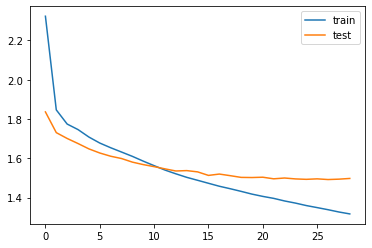

In [39]:
from matplotlib import pyplot
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

In [40]:
reverse_target_word_index=y_tokenizer.index_word
reverse_source_word_index=x_tokenizer.index_word
target_word_index=y_tokenizer.word_index

In [41]:
# Encode the input sequence to get the feature vector
encoder_model = Model(inputs=encoder_inputs,outputs=[encoder_outputs, state_h, state_c])

# Decoder setup
# Below tensors will hold the states of the previous time step
decoder_state_input_h = Input(shape=(latent_dim,))
decoder_state_input_c = Input(shape=(latent_dim,))
decoder_hidden_state_input = Input(shape=(max_text_len,latent_dim))

# Get the embeddings of the decoder sequence
dec_emb2= dec_emb_layer(decoder_inputs) 
# To predict the next word in the sequence, set the initial states to the states from the previous time step
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])

#attention inference
attn_out_inf, attn_states_inf = attn_layer([decoder_hidden_state_input, decoder_outputs2])
decoder_inf_concat = Concatenate(axis=-1, name='concat')([decoder_outputs2, attn_out_inf])

# A dense softmax layer to generate prob dist. over the target vocabulary
decoder_outputs2 = decoder_dense(decoder_inf_concat) 

# Final decoder model
decoder_model = Model(
    [decoder_inputs] + [decoder_hidden_state_input,decoder_state_input_h, decoder_state_input_c],
    [decoder_outputs2] + [state_h2, state_c2])

In [42]:
def decode_sequence(input_seq):
    # Encode the input as state vectors.
    e_out, e_h, e_c = encoder_model.predict(input_seq)
    
    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1,1))
    
    # Populate the first word of target sequence with the start word.
    target_seq[0, 0] = target_word_index['sostok']

    stop_condition = False
    decoded_sentence = ''
    while not stop_condition:
      
        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])

        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = reverse_target_word_index[sampled_token_index]
        
        if(sampled_token!='eostok'):
            decoded_sentence += ' '+sampled_token

        # Exit condition: either hit max length or find stop word.
        if (sampled_token == 'eostok'  or len(decoded_sentence.split()) >= (max_summary_len-1)):
            stop_condition = True

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # Update internal states
        e_h, e_c = h, c

    return decoded_sentence

In [43]:
def seq2summary(input_seq):
    newString=''
    for i in input_seq:
        if((i!=0 and i!=target_word_index['sostok']) and i!=target_word_index['eostok']):
            newString=newString+reverse_target_word_index[i]+' '
    return newString

def seq2text(input_seq):
    newString=''
    for i in input_seq:
        if(i!=0):
            newString=newString+reverse_source_word_index[i]+' '
    return newString

##PREDICTION

In [59]:
predicted = []
title =[]

for i in range(0,100):
    print("Abstract:",seq2text(x_tr[i]))
    print("Original Title:",seq2summary(y_tr[i]))
    print("Predicted Title:",decode_sequence(x_tr[i].reshape(1, max_text_len)))
    print("\n")
    predicted.append(decode_sequence(x_tr[i].reshape(1, max_text_len)))
    title.append(seq2summary(y_tr[i]))

Abstract: models revealed housing insecurity experiences predicted poorer self rated physical health additional chronic conditions even controlling previous physical health moderation analyses indicated housing insecurity stronger relationship chronic conditions among midlife adults compared older adults among black adults compared white adults results suggest experiences housing insecurity leave adults vulnerable compromised physical health housing insecurity experiences may particularly detrimental health midlife black adults conclusions research adds extant literature introducing comprehensive measure housing insecurity experiences contributes life course perspective regarding housing insecurity affect physical health research implications policy addresses housing insecurity public health concern especially aftermath recession economic housing crisis caused covid pandemic 
Original Title: longitudinal analysis relationship housing insecurity physical health among aging adults united

##ROUGE SCORE

In [45]:
! pip install rouge

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [54]:
from rouge import Rouge

In [60]:
rouge = Rouge()
rouge.get_scores(title, predicted,avg=True, ignore_empty=True)

{'rouge-1': {'r': 0.23024999999999995,
  'p': 0.10339693639693637,
  'f': 0.1381351230556726},
 'rouge-2': {'r': 0.09092857142857143,
  'p': 0.036539682539682546,
  'f': 0.04997186876638159},
 'rouge-l': {'r': 0.21791666666666662,
  'p': 0.097043401043401,
  'f': 0.12980358531237018}}

In [69]:
res = pd.DataFrame(predicted)
res.columns = ['predicted']

res.to_csv("/content/drive/MyDrive/Directed/prediction_result1.csv")